In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Table of contents 

- Predictions of day-to-day values 
    - Module temperature from ambient temperature and irradiation
- Predictions of time series  

## Predictions of day-to-day values

### Module temperature from ambient temperature and irradiation
- INPUT: Irradiation & Ambient temp
- OUTPUT: Module Temp
- GRANULARITY: 
    - Meaned time (grouped by)
    - Each day & time

#### Meaned Time

In [4]:
p1_Sensor = pd.read_csv("dataset/Plant_1_Weather_Sensor_Data.csv")
p1_Sensor = p1_Sensor.drop(columns=['SOURCE_KEY', 'PLANT_ID'])
p1_Sensor['DATETIME'] = pd.to_datetime(p1_Sensor['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
p1_Sensor['TIME'] = p1_Sensor['DATETIME'].dt.time
p1_meanedTime = p1_Sensor.groupby('TIME')[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']].mean().reset_index()
p1_meanedTime['TIME_ID']= [x for x in range(p1_meanedTime.shape[0])]


p2_Sensor = pd.read_csv("dataset/Plant_2_Weather_Sensor_Data.csv")
p2_Sensor = p2_Sensor.drop(columns=['SOURCE_KEY', 'PLANT_ID'])
p2_Sensor['DATETIME'] = pd.to_datetime(p2_Sensor['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
p2_Sensor['TIME'] = p2_Sensor['DATETIME'].dt.time
p2_meanedTime = p2_Sensor.groupby('TIME')[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']].mean().reset_index()
p2_meanedTime['TIME_ID']= p1_meanedTime[p1_meanedTime['TIME'] == p2_meanedTime['TIME']]['TIME_ID']


,TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME_ID
0,00:00:00,22.850001,21.016168,0.0,0
1,00:15:00,22.783998,20.967855,0.0,1
2,00:30:00,22.736059,20.928286,0.0,2
3,00:45:00,22.668326,20.889918,0.0,3
4,01:00:00,22.619415,20.868348,0.0,4
...,...,...,...,...,...
91,22:45:00,23.087202,21.260353,0.0,91
92,23:00:00,23.000668,21.198142,0.0,92
93,23:15:00,22.921178,21.129900,0.0,93
94,23:30:00,22.859934,21.049470,0.0,94


c:\Users\Shadow\anaconda3\envs\tgpu\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


EVAL:
- MAE: 0.7666807718645718
- MSE: 1.6790642867845014
- R2: 0.9806043564501703

TEST:
- MAE: 1.378456667182325
- MSE: 3.2705824579015697
- R2: 0.9733976207654598



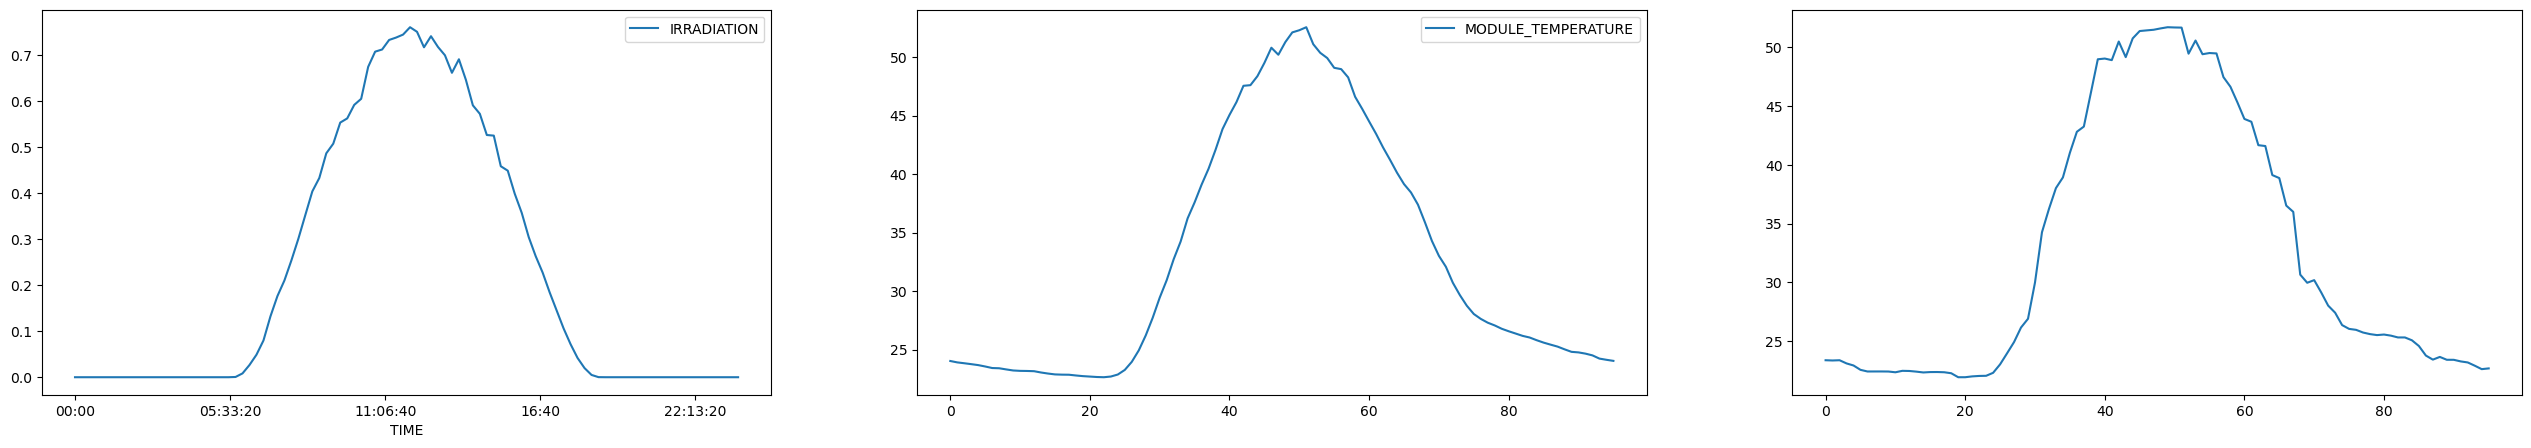

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

X = p1_meanedTime[['TIME_ID', 'AMBIENT_TEMPERATURE','IRRADIATION']]
Y = p1_meanedTime[['MODULE_TEMPERATURE']]
train_x, eval_x, train_y, eval_y = train_test_split(X,Y,test_size=0.25, random_state=42)

forest_regressor = RandomForestRegressor()
forest_regressor.fit(train_x, train_y)
predicted_values = forest_regressor.predict(eval_x)

pred_mae = mean_absolute_error(predicted_values,eval_y)
pred_mse = mean_squared_error(predicted_values,eval_y)
pred_r2 = r2_score(predicted_values,eval_y)

print("EVAL:\n- MAE: {}\n- MSE: {}\n- R2: {}\n".format(pred_mae, pred_mse, pred_r2))

test_x = p2_meanedTime[['TIME_ID', 'AMBIENT_TEMPERATURE','IRRADIATION']]
test_y = p2_meanedTime[['MODULE_TEMPERATURE']]

predicted_values = forest_regressor.predict(test_x)

pred_mae = mean_absolute_error(predicted_values,test_y)
pred_mse = mean_squared_error(predicted_values,test_y)
pred_r2 = r2_score(predicted_values,test_y)

print("TEST:\n- MAE: {}\n- MSE: {}\n- R2: {}\n".format(pred_mae, pred_mse, pred_r2))

fig, axes = plt.subplots(nrows=1, ncols=3)
p1_meanedTime.plot(x='TIME', y='IRRADIATION', ax=axes[0])
test_y.plot(ax=axes[1], figsize=(32,5))
axes[2].plot([i for i in range(len(predicted_values))], predicted_values)

Even if the values are pretty much around expected ones, the curve is a coarser one than the expected one but still follow the schema.

Has we only have 1 entry for each time, using RandomForest for this tasks is not really useful but can give a first glance of we we could do.

##### Each day & time

Now we'll be using all days and times to get more data for training which will give more example and instance to feed ourt model.
**Remark:** I'm fully aware that each day is different and production can widely differ from a day to another, but since lots of parameters influencing this aren't available, only the time, irradiation and temp will be used.
